In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tfs

import matplotlib.pyplot as plt 
import numpy as np
import random
import json
import time

import math
from models import LogisticRegressor, Convolutional

In [2]:
N_EPOCHS = 10
N_FEATURES = 12
W_DIM = 5

In [3]:
train_data = []
test_data = []

n_true, n_false = 0, 0
n_videos = 0

def construct_tensors(matrix, state):
    matrix = np.abs(np.array(matrix))[:W_DIM,1:1+N_FEATURES]
    matrix_norm = matrix / matrix.sum(axis=1)[:,np.newaxis]

    x0 = torch.FloatTensor(matrix[2].flatten())
    x1 = torch.FloatTensor([matrix])
    y = torch.tensor(state)
    return (x0, x1, y)

with open('data/mfccs.json') as f:
    json_data = json.load(f)

    # Loop over all videos in dataset
    for i, video in enumerate(json_data):
        n_videos += 1
        video_data = json_data[video]

        # Loop over all bounces for current video
        for matrix in video_data['true']:
            if matrix != []:
                if i < 5:
                    train_data.append(construct_tensors(matrix, 1))
                else:
                    test_data.append(construct_tensors(matrix, 1))
                n_true += 1

        for matrix in video_data['false']:
            if matrix != []:
                if i < 5:
                    train_data.append(construct_tensors(matrix, 0))
                else:
                    test_data.append(construct_tensors(matrix, 0))
                n_false += 1

print(f'Extracted {len(train_data)+len(test_data)} datapoints ({n_true} true and {n_false} false) from {n_videos} videos')

Extracted 2833 datapoints (944 true and 1889 false) from 10 videos


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=32,
                                           shuffle=True)

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(f'Device: {device}')

Device: cpu


In [6]:
regressor, conv = LogisticRegressor(N_FEATURES, 1, 2).to(device), Convolutional(N_FEATURES, W_DIM, 2).to(device)
print(f'n_params={sum(p.numel() for p in regressor.parameters())}')
print(f'n_params={sum(p.numel() for p in conv.parameters())}')

n_params=902
n_params=256


In [7]:
optis = [optim.SGD(regressor.parameters(), lr=0.01), optim.SGD(conv.parameters(), lr=0.01)]
crits = [nn.CrossEntropyLoss(), nn.CrossEntropyLoss()]

In [8]:
def accuracy(model, data, inds):
    x, y = inds
    correct, total = 0, 0
    for xxy in data:
        y_hat = model(xxy[x].to(device))
        _, predicted = torch.max(y_hat.data, 1)
        
        total += xxy[y].size(0)
        correct += (predicted.cpu() == xxy[y]).sum()

    return 100 * int(correct) / total

def confusion(model, data, inds):
    x, y = inds
    matrix = np.array([[0, 0], [0, 0]])
    exampl = [[[], []], [], []]
    for xxy in data:
        y_hat = model(xxy[x].to(device))
        _, predicted = torch.max(y_hat.data, 1)
        predicted = predicted.cpu()

        matrix[0, 0] += torch.sum((xxy[y] == 1) & (predicted == 1))
        matrix[0, 1] += torch.sum((xxy[y] == 0) & (predicted == 1))
        matrix[1, 0] += torch.sum((xxy[y] == 1) & (predicted == 0))
        matrix[1, 1] += torch.sum((xxy[y] == 0) & (predicted == 0))

    return matrix

def recall(model, data, inds):
    x, y = inds
    tp, fn = 0, 0
    for xxy in data:
        y_hat = model(xxy[x].to(device))
        _, predicted = torch.max(y_hat.data, 1)

        tp += torch.sum((xxy[y] == 1) & (predicted.cpu() == 1))
        fn += torch.sum((xxy[y] == 1) & (predicted.cpu() == 0))
    return int(tp) / (int(tp) + int(fn))


In [9]:
accuracy_histories = [[], []]
n_iters = 0
start = time.time()

for epoch in range(1, N_EPOCHS + 1):
    for i, (x0, x1, y) in enumerate(train_loader):
        # Clear gradients
        optis[0].zero_grad()
        optis[1].zero_grad()

        # Make prediction and calculate loss
        y_hat0 = regressor(x0.to(device)).cpu()
        y_hat1 = conv(x1.to(device)).cpu()

        loss0 = crits[0](y_hat0, y)
        loss1 = crits[1](y_hat1, y)

        # Calculate new gradients and optimize
        loss0.backward()
        loss1.backward()

        optis[0].step()
        optis[1].step()

        if n_iters % 10 == 0 or epoch == N_EPOCHS:
            acc0 = accuracy(regressor, test_loader, (0, 2))
            acc1 = accuracy(conv, test_loader, (1, 2))

            accuracy_histories[0].append(acc0)
            accuracy_histories[1].append(acc1)
            
            fepoch = 'Epoch: \033[92m{}\033[0m/\033[92m{}\033[0m'.format(epoch, N_EPOCHS)
            fiters = 'Iter: \033[92m{}\033[0m'.format(n_iters)
            facc0 = 'Acc0: \033[92m{:.2f}%\033[0m'.format(acc0)
            facc1 = 'Acc1: \033[92m{:.2f}%\033[0m'.format(acc1)
            fptime = 'Time: \033[92m{:.0f}\033[0ms'.format(time.time() - start)

            print('\r{}\t | {}\t | {}, {}\t | {}\t |'.format(fepoch, fiters, facc0, facc1, fptime), end="")
        n_iters += 1

Epoch: 10/10	 | Iter: 409	 | Acc0: 47.77%, Acc1: 47.64%	 | Time: 13s	 |

In [10]:
torch.save(regressor.state_dict(), 'data/models/regressor.pkl')
torch.save(conv.state_dict(), 'data/models/convolutional.pkl')

REGRESSOR CONFUSION MATRIX:
 [[227 253]
 [554 511]]
CONVOLUTIONAL CONFUSION MATRIX:
 [[227 255]
 [554 509]]


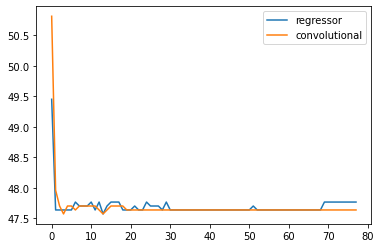

In [11]:
print(f'REGRESSOR CONFUSION MATRIX:\n {confusion(regressor, test_loader, (0, 2))}')
print(f'CONVOLUTIONAL CONFUSION MATRIX:\n {confusion(conv, test_loader, (1, 2))}')

x0, x1 = np.arange(len(accuracy_histories[0])), np.arange(len(accuracy_histories[1]))
plt.plot(x0, accuracy_histories[0], label='regressor')
plt.plot(x1, accuracy_histories[1], label='convolutional')
plt.legend()
plt.show()